In [13]:
import anndata as ad
import anndata2ri
import logging
import numpy as np
import scanpy as sc
import scipy
from scipy.sparse import csr_matrix, issparse
import matplotlib.pyplot as plt

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    # color_map="YlGnBu",
    frameon=False,
)
rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
%%R

library(Seurat)
library(sctransform)
library(scran)
library(BiocParallel)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In [3]:
adata = sc.read("/mnt/storage/adata_QC.h5ad")

In [4]:
adata.X = adata.layers["raw_fragments"]

log1p proportional fitting

In [5]:
# proportional fitting to mean of cell depth
proportional_fitting = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
# log1p transform
adata.layers["log1pPF_normalization"] = sc.pp.log1p(proportional_fitting["X"])
# proportional fitting
adata.layers["PFlog1pPF_normalization"] = sc.pp.normalize_total(
    adata, target_sum=None, layer="log1pPF_normalization", inplace=False
)["X"]

SCTransform

In [6]:
if issparse(adata.X):
    if not adata.X.has_sorted_indices:
        adata.X.sort_indices()
ro.globalenv["adata"] = adata

In [7]:
%%R
seurat_obj = as.Seurat(adata, counts="X", data = NULL)
seurat_obj = RenameAssays(seurat_obj, originalexp = "RNA")
res = SCTransform(object=seurat_obj, method = "glmGamPoi", return.only.var.genes = FALSE)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


In [8]:
norm_x = ro.r("res@assays$SCT@scale.data").T
adata.layers["scTransform_normalization"] = norm_x

In [9]:
ro.globalenv["adata"] = adata

In [10]:
%%R
res = SCTransform(object=seurat_obj, method = "glmGamPoi", return.only.var.genes = FALSE, vst.flavor="v2")

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


In [11]:
norm_x = ro.r("res@assays$SCT@scale.data").T
adata.layers["scTransform_normalization_v2"] = norm_x

Text(0.5, 1.0, 'Distribution of Residuals')

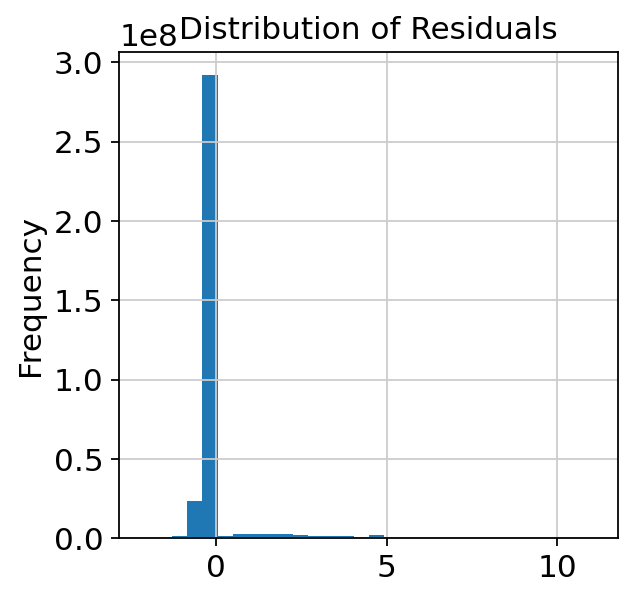

In [14]:
X_res = adata.layers["scTransform_normalization_v2"]
plt.hist(X_res.flatten(), bins = 30)
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')

Text(0.5, 1.0, 'Distribution of Residuals')

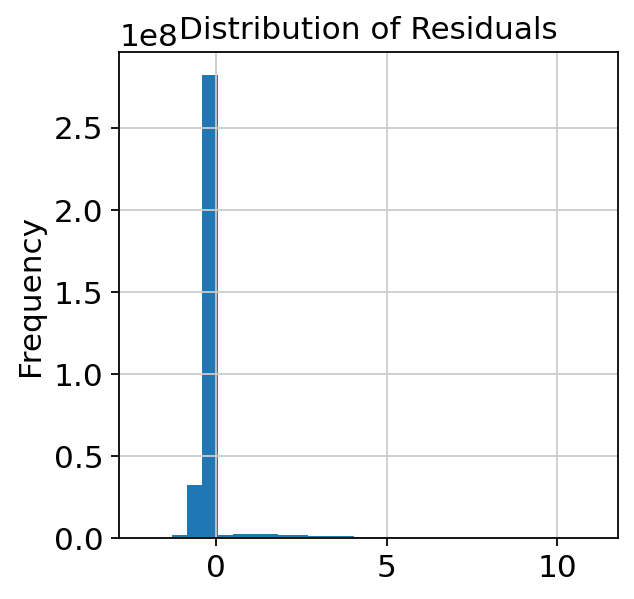

In [15]:
X_res = adata.layers["scTransform_normalization"]
plt.hist(X_res.flatten(), bins = 30)
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')

scran

In [16]:
# Preliminary clustering for differentiated normalisation
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
# Perform log1p transform
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
# Compute neighbours on adata_pp
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="groups")

In [ ]:
data_mat = adata_pp.X.T
# convert to CSC if possible. See https://github.com/MarioniLab/scran/issues/70
if scipy.sparse.issparse(data_mat):
    if data_mat.nnz > 2**31 - 1:
        data_mat = data_mat.tocoo()
    else:
        data_mat = data_mat.tocsc()
ro.globalenv["data_mat"] = data_mat
ro.globalenv["input_groups"] = adata_pp.obs["groups"]
del adata_pp

In [ ]:
%%R -o size_factors

size_factors = sizeFactors(
    computeSumFactors(
        SingleCellExperiment(
            list(counts=data_mat)), 
            clusters = input_groups,
            min.mean = 0.1,
            BPPARAM = MulticoreParam()
    )
)

In [ ]:
adata.obs["size_factors"] = size_factors
# Normalise adata.X with the size factors on store it in the scran variable # TASK
scran = adata.X / adata.obs["size_factors"].values[:, None]
adata.layers["scran_normalization"] = csr_matrix(sc.pp.log1p(scran))

In [ ]:
adata.write("/mnt/storage/adata_normalized.h5ad")